# Chapter 24: Application of the Instrumental Variable Method: Fuzzy Regression Discontinuity Design

In [1]:
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels as lm

# viz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

font = {"family": "IBM Plex Sans Condensed", "weight": "normal", "size": 10}
plt.rc("font", **font)
plt.rcParams["figure.figsize"] = (10, 10)
%matplotlib inline

from utils import *

np.random.seed(42)
%load_ext autoreload
%autoreload 1

%load_ext watermark
%watermark --iversions

statsmodels      : 0.14.0
pandas           : 2.0.3
matplotlib_inline: 0.1.6
linearmodels     : 5.3
seaborn          : 0.13.0
graphviz         : 0.20.1
matplotlib       : 3.7.2
scipy            : 1.11.1
numpy            : 1.24.3



## Asher Novosad (2020)

In [5]:
road_dat = pd.read_csv("indianroad.csv")
road_dat["runv"] = road_dat.left + road_dat.right
pd.crosstab(road_dat.t, road_dat.r2012)

r2012,0,1
t,,
0,4517,1501
1,2821,2593


In [19]:
formula = """occupation_index_andrsn ~
            1 + left + right
            [r2012 ~ t]
           """
seq_h = np.arange(10, 80, 1)


def estfun(h):
    road_sub = road_dat.query("runv.abs() <= @h")
    mod = lm.iv.IV2SLS.from_formula(formula, data=road_sub)
    iv_res2 = mod.fit(cov_type="robust")
    return iv_res2.params[-1], iv_res2.std_errors[-1]


frd_sa = Parallel(n_jobs=-1)(delayed(estfun)(h) for h in seq_h)
res = pd.DataFrame(np.c_[seq_h, np.vstack(frd_sa)], columns=["h", "est", "se"])
res["lb"], res["ub"] = res.est - 1.96 * res.se, res.est + 1.96 * res.se
res.head()

,h,est,se,lb,ub
0,10.0,-0.339655,0.361729,-1.048643,0.369334
1,11.0,-0.357219,0.343950,-1.031361,0.316923
2,12.0,-0.249201,0.331363,-0.898673,0.400270
3,13.0,-0.395528,0.325820,-1.034134,0.243079
4,14.0,-0.396965,0.339812,-1.062997,0.269067


Text(0.5, 1.0, 'Asher-Novosad Roads Fuzzy RD')

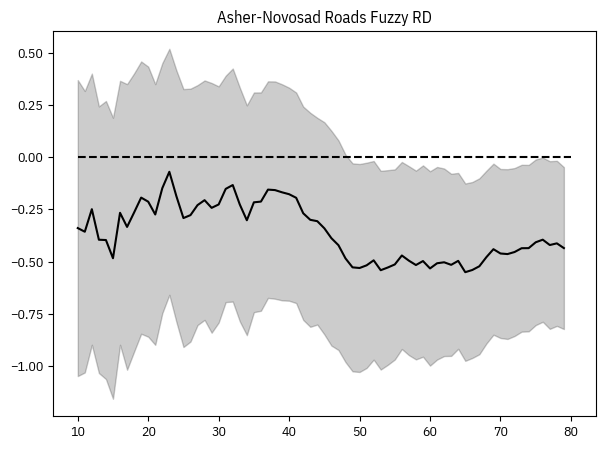

In [23]:
f, ax = plt.subplots(figsize=(7, 5))
ax.plot(res.h, res.est, color="black")
ax.fill_between(res.h, res.lb, res.ub, color="black", alpha=0.2)
ax.hlines(0, 10, 80, color="black", linestyle="--")
ax.set_title("Asher-Novosad Roads Fuzzy RD")

## Li et al (2015)

In [30]:
italy = pd.read_csv("italy.csv")
italy["left"], italy["right"] = np.clip(italy.rv0, None, 0), np.clip(italy.rv0, 0, None)
italy.head()

,outcome,rv0,apply,Z,D,left,right
0,0,-0.366618,1,0,0,-0.366618,0.000000
1,0,-0.381168,1,0,0,-0.381168,0.000000
2,0,0.632612,1,1,1,0.000000,0.632612
3,0,0.613000,1,1,1,0.000000,0.613000
4,0,0.991360,1,1,1,0.000000,0.991360


In [34]:
formula = "outcome ~ 1 + left + right [D ~ Z]"
seq_h = np.arange(0.1, 1, 0.01)


def estfun(h):
    road_sub = italy.query("rv0.abs() <= @h")
    mod = lm.iv.IV2SLS.from_formula(formula, data=road_sub)
    iv_res2 = mod.fit(cov_type="robust")
    return iv_res2.params[-1], iv_res2.std_errors[-1]


frd_sa = Parallel(n_jobs=-1)(delayed(estfun)(h) for h in seq_h)
res = pd.DataFrame(np.c_[seq_h, np.vstack(frd_sa)], columns=["h", "est", "se"])
res["lb"], res["ub"] = res.est - 1.96 * res.se, res.est + 1.96 * res.se
res.head()

,h,est,se,lb,ub
0,0.10,-0.158522,0.151237,-0.454947,0.137903
1,0.11,-0.074280,0.138064,-0.344887,0.196326
2,0.12,-0.044119,0.132984,-0.304767,0.216529
3,0.13,-0.030571,0.127602,-0.280671,0.219528
4,0.14,-0.027312,0.125015,-0.272341,0.217717


Text(0.5, 1.0, 'Li et al (2015) Fuzzy RD')

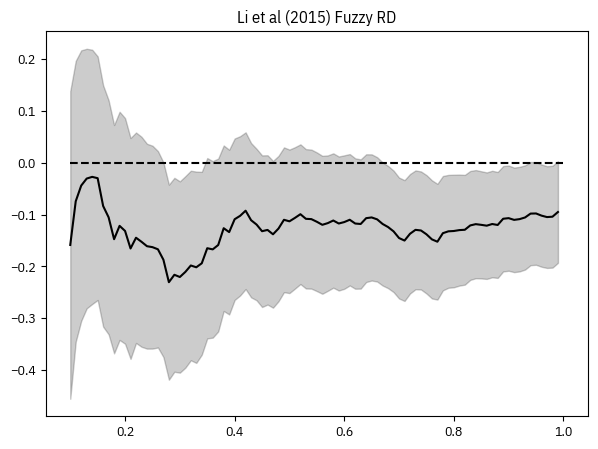

In [37]:
f, ax = plt.subplots(figsize=(7, 5))
ax.plot(res.h, res.est, color="black")
ax.fill_between(res.h, res.lb, res.ub, color="black", alpha=0.2)
ax.hlines(0, 0.1, 1, color="black", linestyle="--")
ax.set_title("Li et al (2015) Fuzzy RD")